In [25]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [53]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from cost_function import cost_function
import optuna

## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(0.5, 0.875, 'smoker <= 0.5\nsquared_error = 144814218.233\nsamples = 1070\nvalue = 13151.19'),
 Text(0.25, 0.625, 'age <= 42.5\nsquared_error = 35840279.579\nsamples = 854\nvalue = 8402.69'),
 Text(0.125, 0.375, 'children <= 0.5\nsquared_error = 20426982.428\nsamples = 483\nvalue = 5350.665'),
 Text(0.0625, 0.125, 'squared_error = 14160743.775\nsamples = 201\nvalue = 3685.17'),
 Text(0.1875, 0.125, 'squared_error = 21506997.523000002\nsamples = 282\nvalue = 6537.773'),
 Text(0.375, 0.375, 'age <= 51.5\nsquared_error = 27991924.722\nsamples = 371\nvalue = 12376.08'),
 Text(0.3125, 0.125, 'squared_error = 24024612.371\nsamples = 159\nvalue = 10411.473'),
 Text(0.4375, 0.125, 'squared_error = 25901573.872\nsamples = 212\nvalue = 13849.536'),
 Text(0.75, 0.625, 'bmi <= 30.01\nsquared_error = 134046573.419\nsamples = 216\nvalue = 31925.353'),
 Text(0.625, 0.375, 'age <= 41.0\nsquared_error = 23305424.05\nsamples = 106\nvalue = 21427.14'),
 Text(0.5625, 0.125, 'squared_error = 8455326.

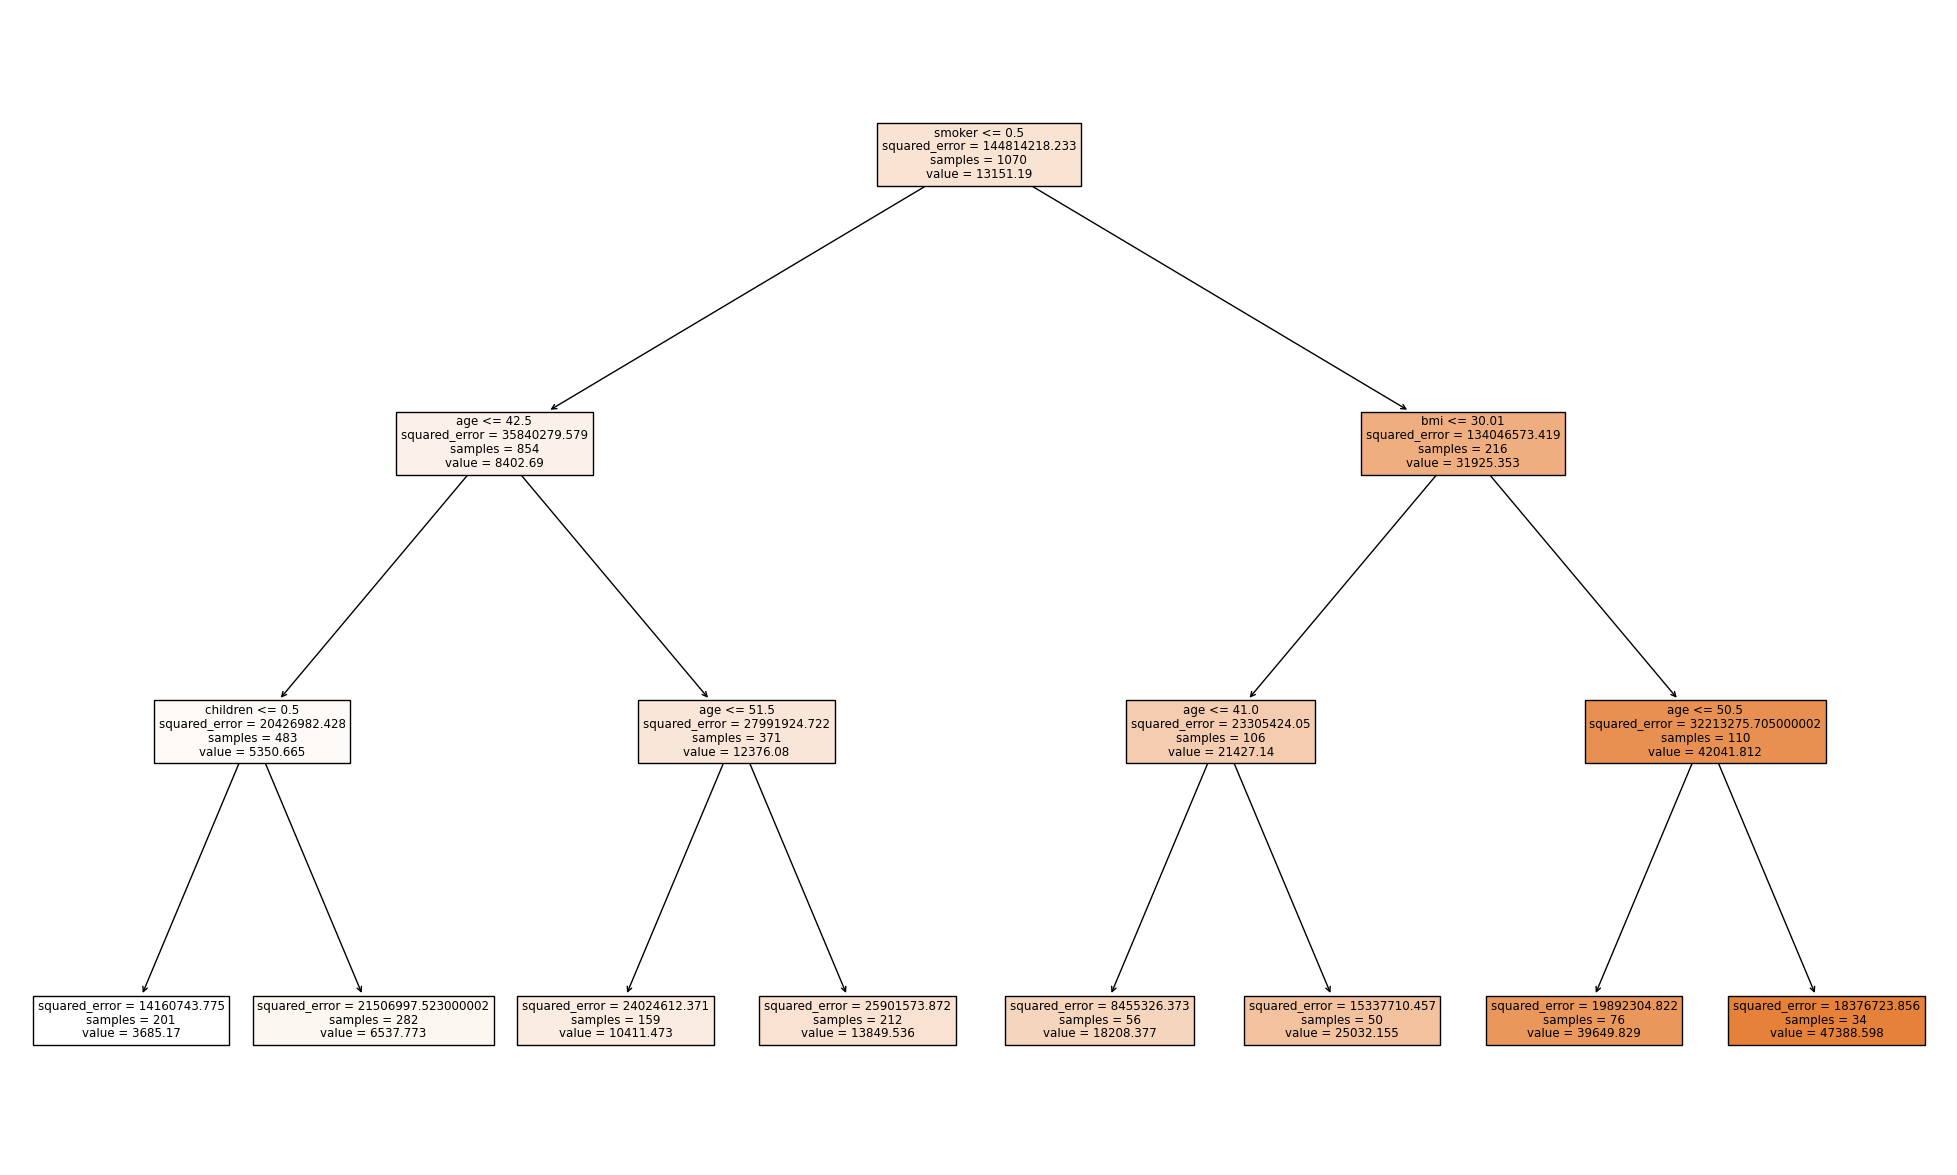

In [55]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [64]:
## Engineering features from decision-tree
insurance['interaction_1'] = np.where((insurance['smoker'] == 0) & (insurance['age'] <= 32.5), 1, 0)
insurance['interaction_2'] = np.where((insurance['smoker'] == 0) & (insurance['age'] > 32.5) & (insurance['age'] <= 44.5), 1, 0)
insurance['interaction_3'] = np.where((insurance['smoker'] == 0) & (insurance['age'] > 44.5) & (insurance['age'] < 51.5), 1, 0)
insurance['interaction_4'] = np.where((insurance['smoker'] == 0) & (insurance['age'] > 51.5), 1, 0)

In [65]:
## Defining the input and target variables
X = insurance[['age', 'bmi', 'children', 'smoker', 'interaction_4']]
Y = insurance['charges']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

### Random Forest

In [66]:
X = X_train
Y = Y_train

class Objective:
    
    def __init__(self, seed):
        self.seed = seed
        
    def __call__(self, trial):
        
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
                      min_samples_split = trial.suggest_int('min_samples_split', 5, 30),
                      min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30),
                      max_depth = trial.suggest_int('max_depth', 2, 10)
                      )
        
        scores = list()
        
        skf = KFold(n_splits = 3, shuffle = True, random_state = self.seed)
        
        for train_idx, valid_idx in skf.split(X, Y):
            
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            Y_train, Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
            
            RF_md = RandomForestRegressor(**params).fit(X_train, Y_train)
            
            pred_valid = RF_md.predict(X_valid)
            score = mean_squared_error(Y_valid, pred_valid)
            scores.append(score)
            
        return np.mean(scores)

In [67]:
SEED = 42
N_TRIALS = 20

## Excuting optuna
study = optuna.create_study(direction = 'minimize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-03-29 17:59:19,130] A new study created in memory with name: no-name-e62c6dac-3828-411c-af30-a90497266489
[I 2023-03-29 17:59:26,978] Trial 0 finished with value: 23893116.511983987 and parameters: {'n_estimators': 1728, 'min_samples_split': 7, 'min_samples_leaf': 25, 'max_depth': 3}. Best is trial 0 with value: 23893116.511983987.
[I 2023-03-29 17:59:33,687] Trial 1 finished with value: 23878623.83616255 and parameters: {'n_estimators': 1407, 'min_samples_split': 10, 'min_samples_leaf': 26, 'max_depth': 7}. Best is trial 1 with value: 23878623.83616255.
[I 2023-03-29 17:59:41,867] Trial 2 finished with value: 22149382.5957875 and parameters: {'n_estimators': 1833, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_depth': 3}. Best is trial 2 with value: 22149382.5957875.
[I 2023-03-29 17:59:44,590] Trial 3 finished with value: 24414711.950973283 and parameters: {'n_estimators': 582, 'min_samples_split': 12, 'min_samples_leaf': 29, 'max_depth': 9}. Best is trial 2 with value

In [68]:
## Building the optimized model
RF_md = RandomForestRegressor(**study.best_trial.params).fit(X_train, Y_train)

## Predicting on test
RF_pred = RF_md.predict(X_test)

## Computing the mse
RF_mse = mean_squared_error(Y_test, RF_pred)
print('The mse of the random forest model is ', RF_mse)

The mse of the random forest model is  16879338.57787259


### XGB

In [69]:
X = X_train
Y = Y_train

class Objective:
    
    def __init__(self, seed):
        self.seed = seed
        
    def __call__(self, trial):
        
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
                      max_depth = trial.suggest_int('max_depth', 2, 10),
                      min_child_weight = trial.suggest_int('min_child_weight', 2, 20),
                      learning_rate = trial.suggest_float('learning_rate', 0.01, 100, log = True),
                      gamma = trial.suggest_float('gamma', 1, 10),
                      colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 0.9),
                      subsample = trial.suggest_float('subsample', 0.2, 0.9)
                      )
        
        scores = list()
        
        skf = KFold(n_splits = 3, shuffle = True, random_state = self.seed)
        
        for train_idx, valid_idx in skf.split(X, Y):
            
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            Y_train, Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
            
            Y_train = np.log(Y_train)
            Y_valid = np.log(Y_valid)
            
            xgb_md = XGBRegressor(**params).fit(X_train, Y_train)
            
            pred_valid = np.log(xgb_md.predict(X_valid))
            score = mean_squared_error(Y_valid, pred_valid)
            scores.append(score)
            
        return np.mean(scores)

In [70]:
SEED = 42
N_TRIALS = 20

## Excuting optuna
study = optuna.create_study(direction = 'minimize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-03-29 18:00:52,516] A new study created in memory with name: no-name-718149cc-608f-48e4-a470-27b693ad5401
[I 2023-03-29 18:00:54,307] Trial 0 finished with value: 48.18971908228468 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 15, 'learning_rate': 0.45892079615468495, 'gamma': 7.663838257113338, 'colsample_bytree': 0.27905164501633006, 'subsample': 0.8411830446021735}. Best is trial 0 with value: 48.18971908228468.
[I 2023-03-29 18:00:54,709] Trial 1 finished with value: 48.17968785672898 and parameters: {'n_estimators': 312, 'max_depth': 10, 'min_child_weight': 18, 'learning_rate': 1.3430962233549144, 'gamma': 2.6043059758835785, 'colsample_bytree': 0.3307153493401652, 'subsample': 0.5181993226669772}. Best is trial 1 with value: 48.17968785672898.
[I 2023-03-29 18:00:56,501] Trial 2 finished with value: 48.19468277787863 and parameters: {'n_estimators': 1087, 'max_depth': 10, 'min_child_weight': 11, 'learning_rate': 1.1651745080513016, 'gamma': 4.5

ValueError: Input contains NaN.